# Setup 

## Libraries 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.patches import Ellipse, Polygon 

# Draw Field 

In [2]:
# function to draw the field background 
def draw_field(ax, alpha = 1): 

    # Set the background color to green
    ax.add_patch(plt.Rectangle(
        xy = (0, 0), 
        height = 120, 
        width = 53.3, 
        color = [0.32, 0.56, 0.23, alpha], 
        zorder = 0 
    )) 

    # add rectangles for the endzones 
    for i in [0, 110]:
        ax.add_patch(plt.Rectangle(
            xy = (0, i), 
            height = 10, 
            width = 53.3, 
            color = [0.22, 0.38, 0.16, alpha], 
            zorder = 1  
        )) 

    # draw a line for every 5 yards 
    for i in range(0, 21):
        ax.plot(
            [0, 53.3], 
            [10 + (i * 5)] * 2, 
            color = 'white', 
            linewidth = [4, 2][i % 2], 
            alpha = alpha, 
            zorder = 2 
        ) 

    # add the hash marks 
    for x in [20.65, 32.65]: # left and right hash marks 
        for y in range(0, 20):
            yc = (y * 5) + 10 
            ax.plot(
                [x] * 2, 
                [yc - 0.5, yc + 0.5], 
                color = 'white', 
                linewidth = 2, 
                alpha = alpha, 
                zorder = 2 
            ) 

    # add markers for each yard line 
    for x in [0.5, 20.65, 32.65, 52.8]:
        for yl in range(0, 100):
            ax.plot(
                [x - 0.5, x + 0.5], 
                [yl + 10] * 2, 
                color = 'white', 
                linewidth = 2, 
                alpha = alpha, 
                zorder = 2 
            ) 

    # add the numbers 
    for i, txt in enumerate(["1 0", "2 0", "3 0", "4 0", "5 0", "4 0", "3 0", "2 0", "1 0"]):
        for x in [8, 53.3 - 8]:
            ax.text(
                x = x, 
                y = (i * 10) + 20, 
                s = txt, 
                color = 'white', 
                fontsize = 44, 
                fontweight = 'bold', 
                horizontalalignment = 'center', 
                verticalalignment = 'center', 
                rotation = -90 if x < 26.65 else 90, 
                alpha = 0.65 * alpha, 
                zorder = 2 
            ) 

# # create the figure and axis 
# fig, ax = plt.subplots(
#     figsize = (width_pixels / dpi, height_pixels / dpi), 
#     dpi = dpi
# ) 

# # draw the field 
# draw_field(ax, alpha = 1) 

# # Set limits and hide axes 
# # ax.set_ylim(0, 120) 
# ax.set_xlim(0, 53.3)
# ax.set_ylim(70, 115) 
# # ax.axis('off') 

# Play Animation 

## Animation Calculations 

In [9]:
# function to take a dictionary of keyframes and create a dataframe from it 
def process_keyframes(keyframes): 

    # initial dataframe 
    dfk = pd.DataFrame() 

    # loop through each frame and create a dataframe for it 
    for frame in keyframes:
        dfk = pd.concat([dfk, pd.DataFrame({
            "TIME": frame['time'], 
            "PARAM": frame['values'].keys(), 
            "VALUE": frame['values'].values() 
        })]) 
    
    # reset the index 
    dfk = dfk.reset_index(drop = True) 

    return dfk 

keyframes = [
    {
        "time": 0, 
        "values": {
            "xc": 30, 
            "yc": 90 
        }
    }, 
    {
        "time": 1, 
        "values": {
            "yc": 100 
        }
    }
] 

dfk = process_keyframes(keyframes) 
dfk 

,TIME,PARAM,VALUE
0,0,xc,30
1,0,yc,90
2,1,yc,100


In [31]:
# function to calculate parameter values at a given time 
def params_at_time(t, dfk): 

    # sort by time 
    dfk = dfk.sort_values(["TIME"]) 

    # get the parameter values before 
    df_before = (
        dfk[dfk["TIME"] <= t].groupby("PARAM").last() 
        .rename(columns = {"TIME": "TIME_BEFORE", "VALUE": "VALUE_BEFORE"}) 
    ) 

    # get the parameter values after
    df_after = (
        dfk[dfk["TIME"] > t].groupby("PARAM").first() 
        .rename(columns = {"TIME": "TIME_AFTER", "VALUE": "VALUE_AFTER"})
    ) 

    # merge the two and add the time 
    df_merged = df_before.merge(df_after, on = ["PARAM"], how = "outer").reset_index()  
    df_merged["TIME"] = t 

    # calculate the interpolated value
    def interp_value(row): 

        # if either is na, return the other 
        if pd.isna(row["VALUE_BEFORE"]): 
            return row["VALUE_AFTER"] 
        elif pd.isna(row["VALUE_AFTER"]): 
            return row["VALUE_BEFORE"] 

        # otherwise, do a linear interpolation 
        else: 
            t0 = row["TIME_BEFORE"] 
            t1 = row["TIME_AFTER"] 
            v0 = row["VALUE_BEFORE"] 
            v1 = row["VALUE_AFTER"] 
            return v0 + (v1 - v0) * ((t - t0) / (t1 - t0)) 
    
    # apply the interpolation function 
    df_merged["VALUE"] = df_merged.apply(interp_value, axis = 1) 

    # transform to a dictionary 
    pdict = {row["PARAM"]: row["VALUE"] for _, row in df_merged.iterrows()}

    return pdict 

pdict = params_at_time(3, dfk) 
pdict 

{'xc': 30, 'yc': 100}

In [32]:
# function to fill in default parameters 
def fill_default_params(pdict, defaults): 

    # loop through defaults and add any missing ones 
    for key, value in defaults.items(): 
        if key not in pdict: 
            pdict[key] = value 
    
    return pdict 

fill_default_params(
    pdict = pdict, 
    defaults = {
        "xc": 0, 
        "yc": 0, 
        "alpha": 1 
    }
) 

{'xc': 30, 'yc': 100, 'alpha': 1}

## PlayAnimation Object 

1260


1260


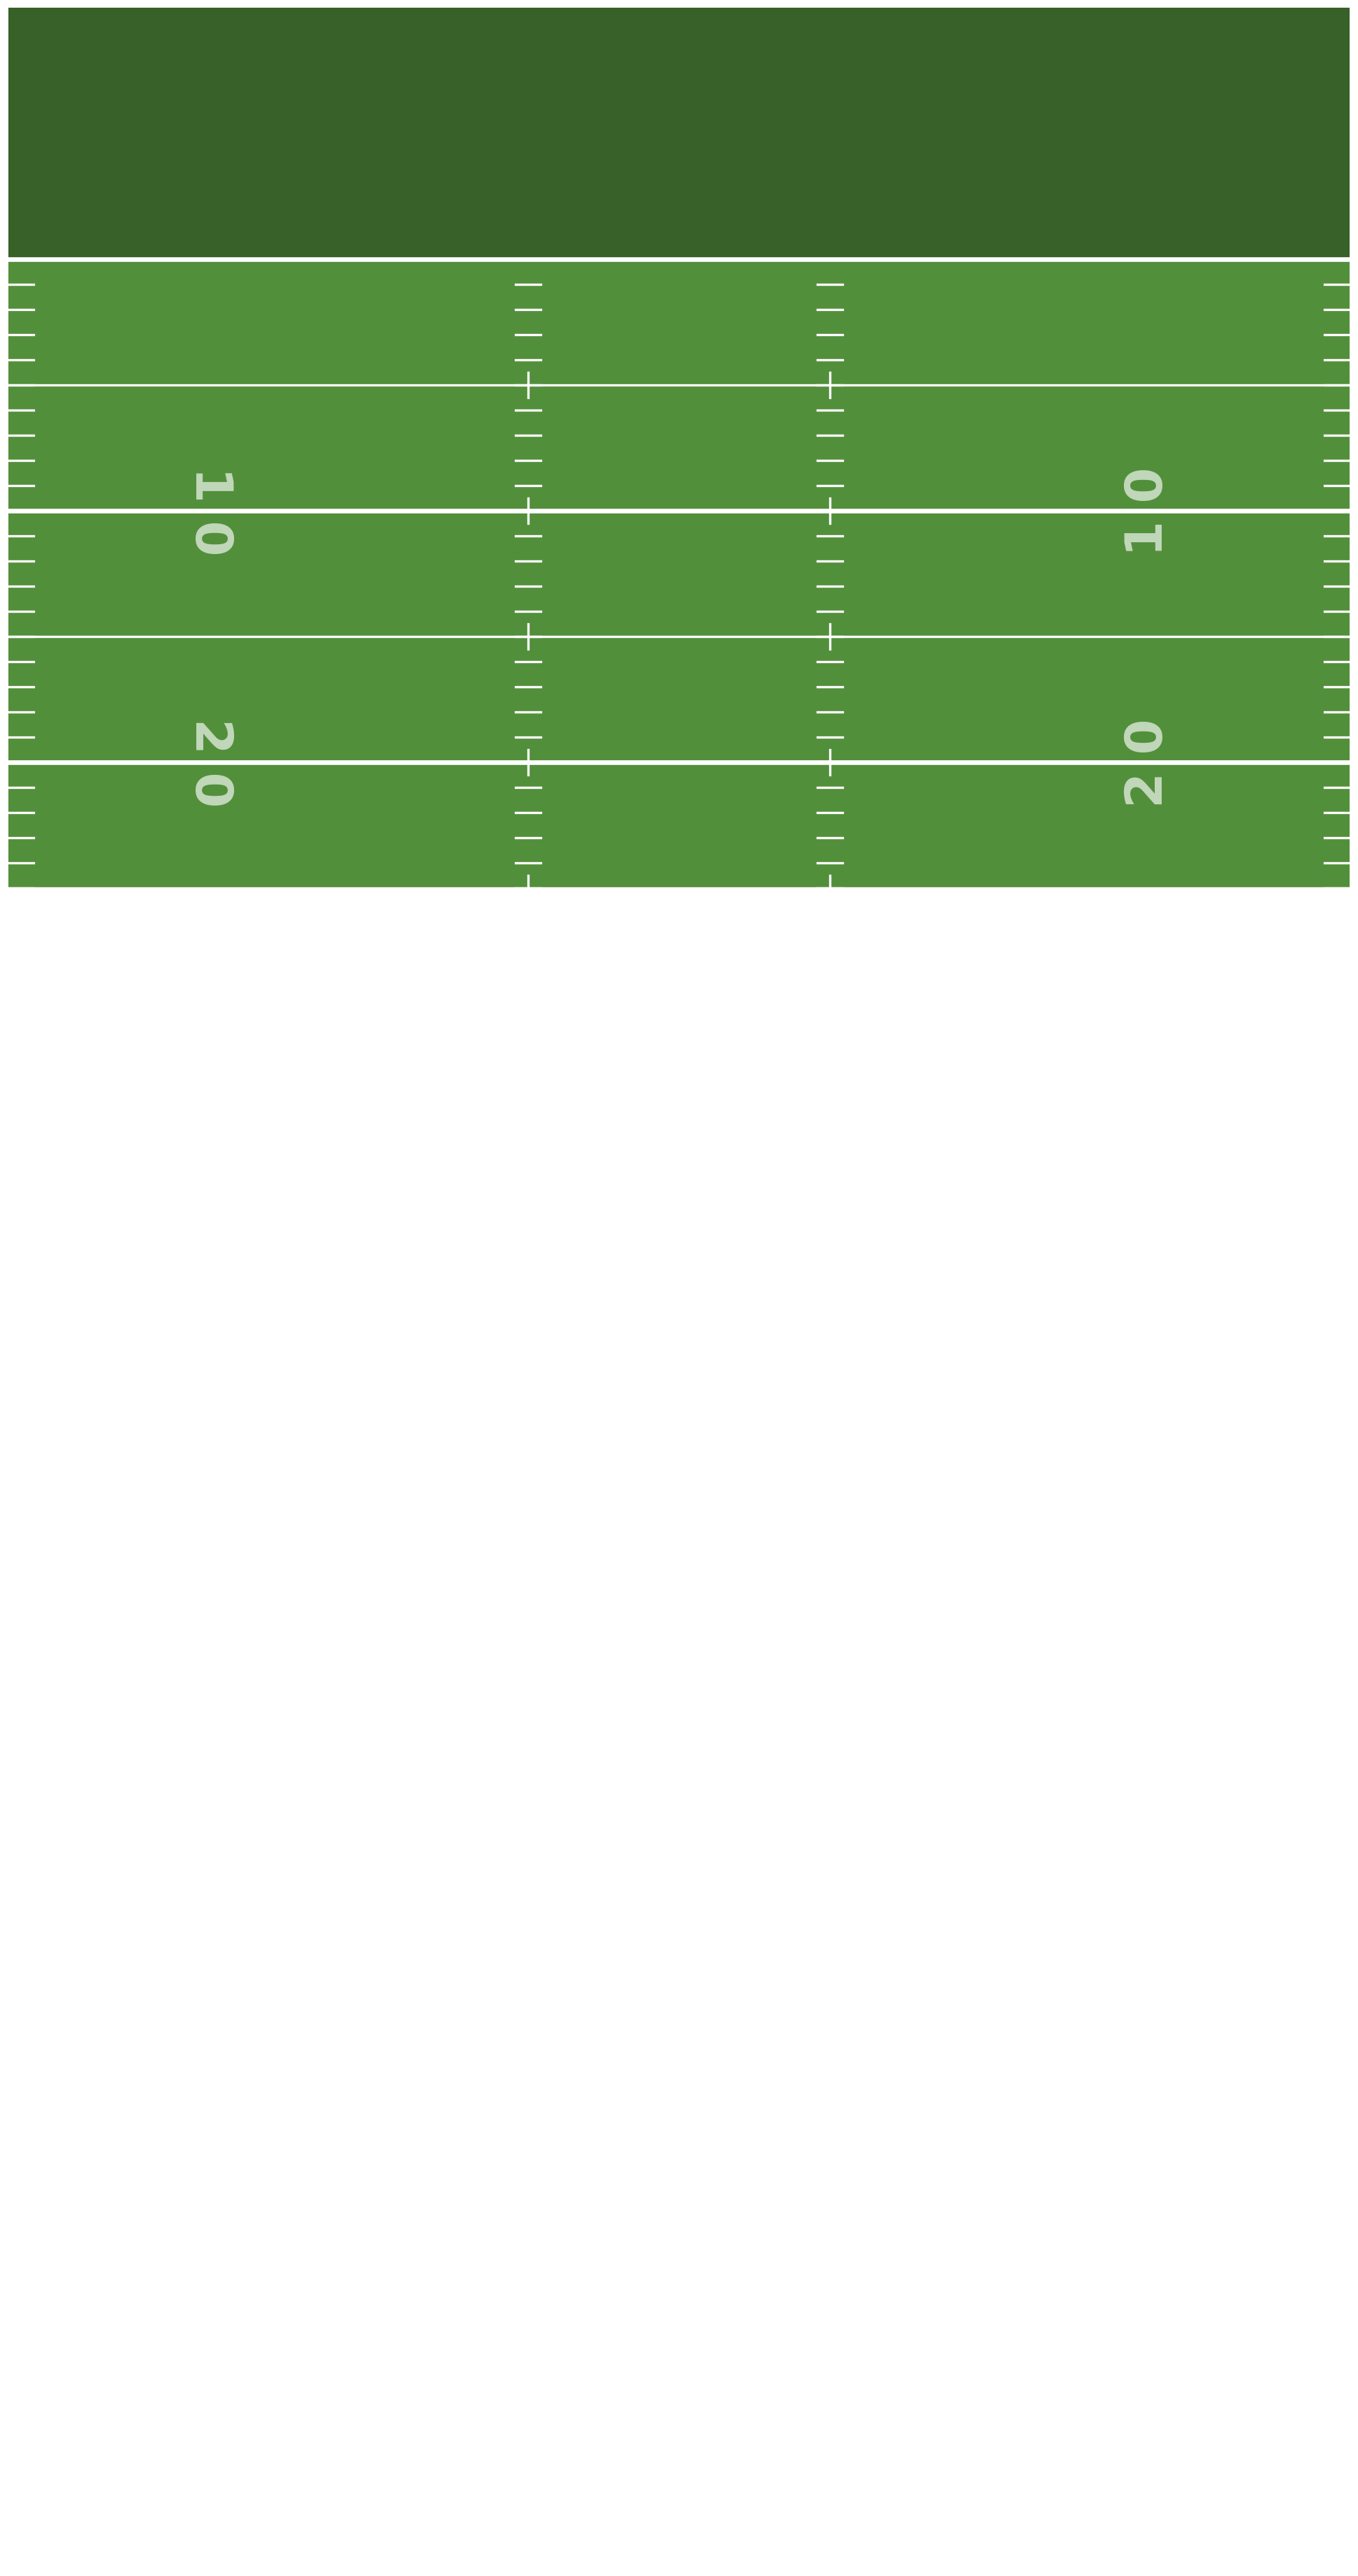

In [ ]:
# class for each play animation 
class PlayAnimation:

    def __init__(self, ystart = 0, yend = 120):
        
        self.ystart = ystart 
        self.yend = yend 
        self.pixels_width = 1920 
        self.pixels_height = int(self.pixels_width * ((yend - ystart) / 53.3)) 
        self.dpi = 120 

        self.players = [] 

        # create the figure and axis 
        self.fig, self.ax = plt.subplots(
            figsize = (self.pixels_width / self.dpi, self.pixels_height / self.dpi), 
            dpi = self.dpi
        )
        
        # Remove all margins to match exact pixel dimensions 
        margin = 5 # pixels 
        self.fig.subplots_adjust(
            left = (margin / self.pixels_width), 
            right = 1 - (margin / self.pixels_width), 
            top = 1 - (margin / self.pixels_height), 
            bottom = (margin / self.pixels_height)
        ) 
    
    def add_player(self, player):
        self.players.append(player) 


    def draw_play(self):

        # draw the field 
        draw_field(self.ax, alpha = 1) 

        # draw out the players 
        for player in self.players:
            player.draw(self.ax) 

        # Set limits and hide axes 
        self.ax.set_xlim(0, 53.3)
        self.ax.set_ylim(self.ystart, self.yend) 
        self.ax.axis('off') 
    
    def test_save(self):
        self.draw_play() 
        
        # save the figure output for testing 
        self.fig.savefig('output_test.png', dpi = self.dpi, pad_inches=0) 

pa = PlayAnimation(ystart = 85, yend = 120) 
pa.test_save() 
plt.close() 

# Add Objects 

In [111]:
def rotate_trapezoid(x, y, angle, dw1=0.25, dw2=1, dh=0.75):
    
    angle_rad = np.radians(angle)
    
    corners = [[-dw1, 0], [-dw2, dh], [dw2, dh], [dw1, 0]]
    rotated_corners = []
    
    for cx, cy in corners:
        new_x = cx * np.cos(angle_rad) - cy * np.sin(angle_rad) + x
        new_y = cx * np.sin(angle_rad) + cy * np.cos(angle_rad) + y
        rotated_corners.append([new_x, new_y])
    
    return rotated_corners 

rotate_trapezoid(
    x = 0, 
    y = 0, 
    angle = 180, 
    dw1 = 0.25, 
    dw2 = 1, 
    dh = 0.75 
)

[[np.float64(0.25), np.float64(-3.061616997868383e-17)],
 [np.float64(0.9999999999999999), np.float64(-0.7500000000000001)],
 [np.float64(-1.0), np.float64(-0.7499999999999999)],
 [np.float64(-0.25), np.float64(3.061616997868383e-17)]]

In [105]:
# dimensions for the center of the smaller side 
x = 0 
y = 0 

# dimensions for the trapezoid 
dw1 = 0.25 
dw2 = 1   
dh = 0.75  

# calculate the four corners of the trapezoid 
[[x - dw1, y], [x - dw2, y + dh], [x + dw2, y + dh], [x + dw1, y]] 

[[-0.25, 0], [-1, 0.75], [1, 0.75], [0.25, 0]]

In [ ]:
# function to draw out a player 
def draw_player(ax, x, y, angle = 0, pcolor = "red", alpha = 1, show_direction = True):

    # draw the body ellipse 
    ax.add_patch(Ellipse(
        xy = (x, y), 
        width = 1.5, 
        height = 0.75, 
        angle = -angle, 
        facecolor = pcolor, 
        edgecolor = "black", 
        linewidth = 2,
        zorder = 25, 
        alpha = alpha 
    )) 

    # draw the head ellipse 
    ax.add_patch(Ellipse(
        xy = (x, y), 
        width = 0.5, 
        height = 0.5, 
        angle = -angle, 
        facecolor = pcolor, 
        edgecolor = "black", 
        linewidth = 2,
        zorder = 26, 
        alpha = alpha 
    )) 

    # draw the direction indicator 
    if show_direction: 

        # trapezoid dimensions  
        dw1 = 0.25 
        dw2 = 1   
        dh = 0.75  

        # calculate rotated corners 
        angle_rad = np.radians(-angle) 
        corners = [[-dw1, 0], [-dw2, dh], [dw2, dh], [dw1, 0]]
        rotated_corners = [] 
        for cx, cy in corners:
            new_x = cx * np.cos(angle_rad) - cy * np.sin(angle_rad) + x
            new_y = cx * np.sin(angle_rad) + cy * np.cos(angle_rad) + y
            rotated_corners.append([new_x, new_y])

        # draw the polygon 
        ax.add_patch(Polygon(
            rotated_corners, 
            facecolor = "yellow", 
            edgecolor = None, 
            alpha = 0.65 * alpha, 
            zorder = 24 
        ))

pa = PlayAnimation(ystart = 85, yend = 120) 

draw_player(pa.ax, x = 24, y = 93, angle = 150, pcolor = "blue")
draw_player(pa.ax, x = 25, y = 91, angle = 0, pcolor = "red")

# save and close 
pa.test_save() 
plt.close() 

In [ ]:
# object for showcasing players 
class PlayerObject:

    def __init__(self, pcolor = "red"): 

        self.pcolor = pcolor 

    def draw(self, ax): 
        pass 

# player1 = PlayerObject() 

